In [1]:
import os
import numpy as np
import torch
import scipy.io
import scipy.signal
import picard
import sklearn.preprocessing
import matplotlib.pyplot as plt

In [2]:
show = __name__ == "__main__"

In [3]:
dataset = torch.load("dataset.pt", weights_only=True)

for key, value in dataset["metadata"].items():
    locals()[key] = value

data = dataset['data']
labels = dataset['labels']
subjects = dataset['subjects']

for key, value in dataset["metadata"].items():
    locals()[key] = value

In [4]:
def normalize(data, dim=None):
    means = data.mean(dim=dim, keepdim=True)
    stds = data.std(dim=dim, keepdim=True)
    data -= means
    data /= stds
    return data
    
if show:
    data_normal = normalize(data, dim=2)

In [5]:
def common_average_referencing(data, dim=None, residual=False):
    means = data.mean(dim=dim, keepdim=True)
    data -= means
    if residual:
        return torch.cat([data, means], dim=dim)
    return data

if show:
    data_car = common_average_referencing(data, dim=1)

In [6]:
if show:
    data_normal_car = normalize(common_average_referencing(data, dim=1), dim=2)
    print(data_normal_car.shape)    

torch.Size([9315, 6, 4096])


In [7]:
# Super naive spike thesholdning. Everything beyond +/- 1 SD is a spike.
def abs_threshold(data, threshold=1):
    return (data.abs() > 1).float()


In [8]:
if show:
    spikes = abs_threshold(data_normal_car, threshold=1)
    print(spikes.shape)

torch.Size([9315, 6, 4096])


In [9]:
if show:
    print(spikes)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0

In [10]:
# Naive spike thesholdning. Everything beyond +/- 1 SD is a spike.
def pol_threshold(data, threshold=1, dim=1):
    return torch.cat(((data > threshold).float(), (data < -threshold).float()), dim=dim)

In [11]:
if show:
    spikes_pol = pol_threshold(data_normal_car, threshold=1, dim=1)
    spikes_pol.shape

In [12]:
def delta_coding(data, delta=0.1):
    quantized = (data / delta).to(int)
    diff = torch.diff(quantized, dim=2, prepend=data[:,:,:1])
    # This wasn't exactly obvious. floor(1.5) is 1 while floor (-1.5) is -2
    spikes_delta = torch.cat((
        torch.floor(diff).clamp(min=0),
        -torch.ceil(diff).clamp(max=0),
    ), dim=1).to(torch.float32)
    return spikes_delta


In [13]:
if show:
    spikes_delta = delta_coding(data_normal_car, delta=0.1)
    print(spikes_delta.shape)

torch.Size([9315, 12, 4096])


In [14]:
if show:
    print(spikes_delta[0,0,1000:1100], spikes_delta[0,7,1000:1100])

tensor([1., 0., 2., 1., 1., 1., 1., 2., 1., 2., 2., 1., 2., 2., 2., 1., 2., 2.,
        1., 1., 2., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) tensor([-0., 1., -0., 1., -0., -0., 1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 1., -0., 1., -0., 1., 1., 2.,
        1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., -0., 1., -0., 1., 1., -0.,
        1., -0., 1., 1., 1., 1., -0., 1., 1., -0.])


In [15]:
if show:
    print(spikes_delta[0,0,:].sum(), spikes_delta[0,7,:].sum())

tensor(905.) tensor(853.)


In [16]:
def rate_coding(data, sensitivity=0.1):
    spikes_quant = data / sensitivity
    spikes_rate = torch.cat((
        torch.floor(spikes_quant).clamp(min=0),
        -torch.ceil(spikes_quant).clamp(max=0),
    ), dim=1).to(int).to(torch.float32)
    return spikes_rate


In [17]:
if show:
    spikes_rate = rate_coding(data_normal_car, sensitivity=0.1)
    print(spikes_rate[0,0,:].sum(), spikes_rate[0,7,:].sum())

tensor(14238.) tensor(14238.)


In [18]:
if show:
    print(spikes_rate.shape)

torch.Size([9315, 12, 4096])


In [19]:
if show:
    spikes_rate[0,0,1000:1100], spikes_rate[0,7,1000:1100]

In [20]:
def bin_sum(data, size, dim=-1):
    '''Bin the data into fewer bins by summation, analogous to Tonic.ToFrame. Implementation by ChatGPT.'''
    total_indices = data.size(dim)
    quotient, remainder = divmod(total_indices, size)
    bin_sizes = [quotient + (1 if i >= size - remainder else 0) for i in range(size)]
    splits = torch.split(torch.arange(total_indices), bin_sizes)
    return torch.stack([data.index_select(dim, idx).sum(dim=dim) for idx in splits], dim=dim)

In [21]:
def collate(batch):
    events, targets = zip(*batch)
    events = torch.stack(events).permute(2, 0, 1)
    targets = torch.stack(targets)
    return events, targets

In [22]:
def downsample(data, in_rate=rate, out_rate=rate//8):
    samples = data.size(-1) * out_rate // in_rate
    result = scipy.signal.resample(data.cpu().numpy(), samples, axis=-1)
    return torch.tensor(result, device=data.device, dtype=data.dtype)

In [23]:
if show:
    data_downsampled = downsample(data)
    print(data_downsampled.shape, data_downsampled)

torch.Size([9315, 6, 512]) tensor([[[-5.6440e-01, -1.3465e-01,  5.3643e-01,  ..., -3.6973e-01,
          -2.2805e-01, -6.5275e-02],
         [-1.5260e-01,  5.2418e-02,  3.7649e-02,  ..., -2.1199e-01,
          -2.6564e-01, -2.6839e-01],
         [-1.3406e+00, -1.1242e+00,  5.8785e-01,  ...,  3.2872e-02,
          -2.4551e-01,  1.7649e-01],
         [ 5.0264e-01,  9.4376e-01,  2.5399e-02,  ..., -4.7949e-01,
          -7.8102e-01, -1.1629e+00],
         [ 2.3762e-01, -8.0104e-01, -1.2238e+00,  ...,  8.4811e-01,
           7.1667e-01,  6.4377e-01],
         [ 1.4567e+00,  1.2526e+00, -3.1159e-03,  ...,  1.0986e-01,
           6.9921e-01,  4.9365e-01]],

        [[ 7.7283e-01,  2.2104e-01, -1.7966e-01,  ...,  1.2105e+00,
           1.1410e+00,  1.1509e+00],
         [ 8.1522e-01,  6.8938e-01,  6.7538e-01,  ...,  1.2152e-03,
           3.7902e-01,  7.1207e-01],
         [-2.0878e-02,  4.7478e-01, -6.6236e-01,  ..., -2.0286e-01,
          -1.4239e-01, -2.6990e-01],
         [ 1.2571e-01,  3.

In [24]:
import warnings

# Never mind the warnings...
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.base")

def ica(data, max_iter=500, tol=1e-8, whiten=True, ortho=False):
    results = []
    for d in data:
        d = d.transpose(0, 1)
        transform = picard.Picard(d.size(1), max_iter=max_iter, tol=tol, whiten=whiten, ortho=ortho)
        result = torch.tensor(transform.fit_transform(d.cpu()),
                              dtype=data.dtype,
                              device=data.device).transpose(0, 1)
        results.append(result)
    return torch.stack(results)

In [25]:
if show:
    y = ica(data_downsampled)
    print(y.shape, y[0])

torch.Size([9315, 6, 512]) tensor([[-0.0854, -0.1135, -0.0207,  ...,  0.0366,  0.0065,  0.0301],
        [ 0.0455, -0.0207, -0.0768,  ...,  0.0510,  0.0720, -0.0448],
        [-0.0170,  0.0057,  0.0345,  ..., -0.0107, -0.0339, -0.0020],
        [-0.0321, -0.0087,  0.0563,  ..., -0.0135,  0.0145, -0.0096],
        [ 0.0595, -0.0071, -0.0673,  ...,  0.0494,  0.0767,  0.1006],
        [-0.0286, -0.0578, -0.0998,  ...,  0.0111, -0.0541, -0.0869]])


In [26]:
# This was provided by o1 based on the disussion here:
# https://chatgpt.com/share/67669e9c-ebd8-8007-92f0-70579f58cc9a

def ica_fit_and_transform(
    data: torch.Tensor,      # shape [N, C, T]
    train_mask: torch.Tensor,# shape [N], boolean or long indices
    max_iter: int = 1000,
    tol: float = 1e-6
) -> torch.Tensor:
    """
    Learn a single ICA decomposition on all training-set trials, 
    then apply that unmixing to the entire dataset.

    Args:
        data (torch.Tensor): 
            EEG data of shape [num_trials, num_channels, num_timepoints].
        train_mask (torch.Tensor): 
            Boolean or index mask of shape [num_trials] indicating which trials are training.
        max_iter (int): 
            Maximum number of Picard iterations.
        tol (float): 
            Tolerance for the stopping criterion in Picard.

    Returns:
        torch.Tensor: 
            ICA-transformed data of shape [num_trials, num_channels, num_timepoints].
            Each trial has the same shape as input but in the ICA component space.
    """

    device = data.device
    dtype = data.dtype

    # ------------------------------------------
    # 1) EXTRACT & CONCATENATE ALL TRAINING TRIALS
    # ------------------------------------------
    # data[train_mask] has shape [n_train, C, T]
    train_data = data[train_mask]
    n_train, C, T = train_data.shape

    # We want shape [n_samples, n_features] = [n_train*T, C]
    # So permute to [n_train, T, C], then reshape
    # => shape [n_train*T, C]
    train_data_2d = train_data.permute(0, 2, 1).reshape(-1, C)

    # Move to CPU if necessary, because Picard typically runs on NumPy
    train_data_np = train_data_2d.cpu().numpy()

    # ------------------------------------------
    # 2) FIT ICA ON ALL TRAINING DATA
    # ------------------------------------------
    ica_transform = picard.Picard(
        n_components=C, 
        max_iter=max_iter, 
        tol=tol
    )
    ica_transform.fit(train_data_np)

    # ------------------------------------------
    # 3) APPLY ICA TO ALL TRIALS (TRAIN/VAL/TEST)
    # ------------------------------------------
    results = []
    N = data.shape[0]
    for i in range(N):
        # Each trial: shape [C, T]
        trial = data[i]  
        # Transpose to [T, C] for transform()
        trial_t = trial.transpose(0, 1).cpu().numpy()

        # Transform with the learned unmixing
        trial_ica = ica_transform.transform(trial_t)  
        # => shape [T, C]

        # Convert back to Torch, and transpose to [C, T] if desired
        trial_ica_torch = torch.tensor(
            trial_ica, dtype=dtype, device=device
        ).transpose(0, 1)

        results.append(trial_ica_torch)

    # Stack back into [N, C, T]
    return torch.stack(results, dim=0)

In [27]:
if show:
    train_mask = torch.rand((len(data_downsampled),)) < 0.8
    z = ica_fit_and_transform(data_downsampled, train_mask=train_mask)
    print(z.shape, z[0])

torch.Size([9315, 6, 512]) tensor([[ 6.2618e-04,  1.8022e-04, -6.1870e-04,  ...,  2.6138e-04,
          4.7135e-04,  3.1608e-04],
        [ 3.7090e-04,  6.8706e-04,  2.1199e-04,  ..., -3.1555e-04,
         -3.3381e-04, -5.1136e-04],
        [-3.7752e-05,  1.1475e-04,  2.0680e-04,  ..., -1.4198e-04,
         -6.9374e-05, -7.0942e-05],
        [ 5.4153e-04,  1.3192e-04, -5.0859e-04,  ...,  2.7986e-04,
          4.0315e-04,  2.7417e-04],
        [-1.5841e-04, -1.9876e-04,  7.9294e-05,  ...,  1.1037e-04,
         -5.1634e-07,  6.6152e-05],
        [-4.0922e-04, -5.6903e-04, -5.9870e-04,  ...,  8.9654e-05,
         -4.5638e-04, -5.9191e-04]])


In [28]:
def bandpass_filter(data, low=2, high=40, rate=1024, order=10):
    sos = scipy.signal.butter(order, [low / rate / 2, high / rate / 2], btype='band', output='sos')
    return torch.tensor(scipy.signal.sosfilt(sos, np.ascontiguousarray(data.cpu())), dtype=data.dtype, device=data.device)

In [29]:
def bandpass_filter(data=None, low=2, high=40, rate=1024, order=100, axis=-1, zero_phase=True):
    sos = scipy.signal.butter(order, [low / (rate / 2), high / (rate / 2)], btype='band', output='sos')
    if data is None:
        return sos
        
    np_data = np.ascontiguousarray(data.detach().cpu().numpy())
    
    if zero_phase:
        op = scipy.signal.sosfiltfilt
    else:
        op = scipy.signal.sosfilt
        
    filtered = op(sos, np_data, axis=axis)
    # Fix stride issues with filtfilt.
    filtered = filtered.copy()
        
    return torch.from_numpy(filtered).type_as(data).to(data.device)

In [30]:
if show:
    a = bandpass_filter(data)
    print(a.shape, a[0])

torch.Size([9315, 6, 4096]) tensor([[-0.0341,  0.0824,  0.1976,  ...,  0.2582,  0.2042,  0.1484],
        [-0.0069,  0.0319,  0.0698,  ...,  0.3697,  0.3468,  0.3222],
        [-0.0412,  0.1496,  0.3398,  ..., -0.2417, -0.2315, -0.2202],
        [ 0.0372, -0.0530, -0.1423,  ..., -0.0735,  0.0254,  0.1265],
        [-0.0258, -0.1558, -0.2848,  ..., -0.2713, -0.2737, -0.2754],
        [ 0.0778, -0.0707, -0.2185,  ..., -0.0257, -0.0427, -0.0599]])


/tmp/ipykernel_276506/1008282864.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


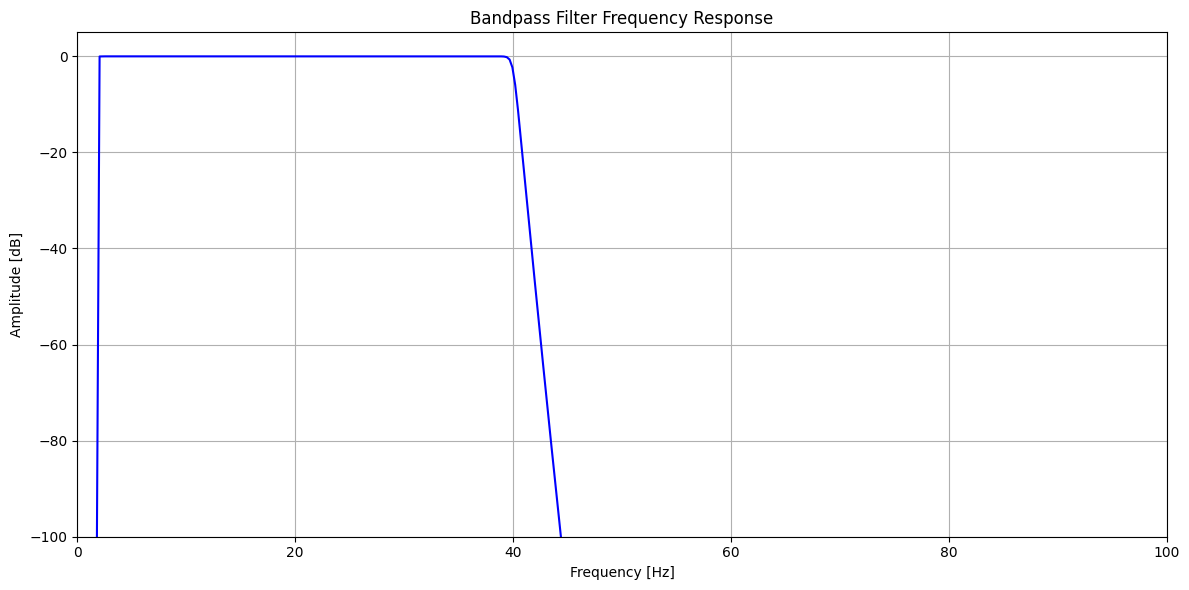

In [38]:
if show:
    w, h = scipy.signal.sosfreqz(bandpass_filter(), worN=2000, fs=rate)

    plt.figure(figsize=(12, 6))
    
    plt.plot(w, 20 * np.log10(abs(h)), 'b')
    plt.title('Bandpass Filter Frequency Response')
    plt.ylabel('Amplitude [dB]')
    plt.xlabel('Frequency [Hz]')
    plt.grid(True)
    plt.xlim(0, 100)
    plt.ylim(-100, 5)
        
    plt.tight_layout()
    plt.show()

In [32]:
def robust_scaler(data):
    scaled = sklearn.preprocessing.RobustScaler().fit_transform(data.cpu().numpy().reshape(-1, data.shape[-1]))
    return torch.tensor(scaled.reshape(data.shape), dtype=data.dtype, device=data.device)

In [33]:
if show:
    b = robust_scaler(data)
    print(b.shape, b[0])

torch.Size([9315, 6, 4096]) tensor([[-6.9098e-01, -6.3753e-01, -5.7307e-01,  ..., -1.3462e-01,
         -1.6671e-01, -2.0520e-01],
        [-5.3998e-02, -3.4501e-02, -1.8557e-02,  ..., -1.9996e-01,
         -2.2258e-01, -2.5000e-01],
        [-1.9141e+00, -1.8303e+00, -1.7205e+00,  ...,  2.3163e-02,
          3.0455e-02,  3.7434e-02],
        [ 1.1553e+00,  1.1085e+00,  1.0510e+00,  ..., -5.7131e-01,
         -5.1752e-01, -4.5665e-01],
        [ 5.1274e-02, -1.6231e-03, -6.6230e-02,  ...,  4.4022e-01,
          4.3850e-01,  4.4245e-01],
        [ 1.7515e+00,  1.6919e+00,  1.6107e+00,  ...,  3.8108e-01,
          3.7139e-01,  3.7861e-01]])


In [34]:
excel_vowel_counts = {
    'A': 672,
    'E': 660,
    'I': 662,
    'O': 655,
    'U': 667
}

In [35]:
# Tripple check that the 0 index of the labels is modality, 1 is stimuli and that
# the totals are correct compared to the Excel file distributed with the data.
for i, vowel in enumerate("AEIOU"):
    assert ((labels[:,0] == 0) & (labels[:,1] == i)).sum() == excel_vowel_counts[vowel]